<a href="https://colab.research.google.com/github/Data-Creater-Atlas/Data-Atlas/blob/Seongjong/mission2_0918.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# 2. 필요한 라이브러리 설치
!pip install pandas torch torchvision scikit-learn tqdm --quiet

#  라이브러리 import
import os
import json
import zipfile
import shutil
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import mean_squared_error

In [4]:
# 3. GPU 사용 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("-" * 30)
print(f"Using device: {DEVICE}")

------------------------------
Using device: cuda


In [6]:
# 4. 핵심 경로 변수 정의
from pathlib import Path

#  경로 정의
# Google Drive에 있는 원본 데이터 경로를 DATA_ROOT로 직접 지정합니다.
DATA_ROOT = Path("/content/drive/MyDrive/Data Camp/53.대기오염 배출원 공간 분포 데이터/3.개방데이터/1.데이터")

# 하위 데이터 경로 변수 설정
TRAIN_IMG_DIR = DATA_ROOT / "Training" / "01.원천데이터" / "TS_KS"
TRAIN_LBL_DIR = DATA_ROOT / "Training" / "02.라벨링데이터" / "TL_KS_LINE"
VAL_IMG_DIR = DATA_ROOT / "Validation" / "01.원천데이터" / "VS_KS"
VAL_LBL_DIR = DATA_ROOT / "Validation" / "02.라벨링데이터" / "VL_KS_LINE"

# 전처리된 데이터(인덱스 파일)를 저장할 폴더
PREPROCESSED_DIR = DATA_ROOT / "ResNet_Dataset"
PREPROCESSED_DIR.mkdir(exist_ok=True)

print("핵심 경로 변수들이 Google Drive 기준으로 설정되었습니다.")
print(f"DATA_ROOT: {DATA_ROOT}")

핵심 경로 변수들이 Google Drive 기준으로 설정되었습니다.
DATA_ROOT: /content/drive/MyDrive/Data Camp/53.대기오염 배출원 공간 분포 데이터/3.개방데이터/1.데이터


In [7]:
# 5. JSON 파싱 함수 정의
from tqdm import tqdm
import pandas as pd
import json

def parse_line_labels_to_df(image_dir: Path, label_dir: Path, desc="Parsing"):
    """JSON 라벨 디렉토리를 순회하며 DataFrame을 생성하는 함수"""
    items = []
    json_files = sorted(label_dir.glob("*.json"))

    for jf in tqdm(json_files, desc=desc):
        with open(jf, "r", encoding="utf-8") as f:
            data = json.load(f)

        for entry in data.values():
            filename = entry.get("filename")
            if not filename: continue

            img_path = image_dir / filename
            if not img_path.exists(): continue

            for region in entry.get("regions", []):
                attrs = region.get("region_attributes", {})
                shape = region.get("shape_attributes", {})

                height = attrs.get("chi_height_m")
                name = shape.get("name", "").lower()

                try:
                    height = float(height)
                except (ValueError, TypeError):
                    continue

                x1, y1, x2, y2 = None, None, None, None
                if name == "line":
                    x1, y1, x2, y2 = shape.get("x1"), shape.get("y1"), shape.get("x2"), shape.get("y2")
                elif name == "polyline":
                    xs, ys = shape.get("all_points_x", []), shape.get("all_points_y", [])
                    if len(xs) >= 2:
                        x1, y1, x2, y2 = xs[0], ys[0], xs[-1], ys[-1]

                if all(v is not None for v in [x1, y1, x2, y2]):
                    items.append({
                        "img_path": str(img_path), "height": height,
                        "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                    })

    return pd.DataFrame(items)

print("JSON 파싱 함수가 정의되었습니다.")

JSON 파싱 함수가 정의되었습니다.


In [8]:
# 6. DataFrame 생성 및 저장
# 학습 및 검증 데이터프레임 생성
print("학습 데이터 파싱 중...")
train_df = parse_line_labels_to_df(TRAIN_IMG_DIR, TRAIN_LBL_DIR, desc="Train Labels")
print("검증 데이터 파싱 중...")
valid_df = parse_line_labels_to_df(VAL_IMG_DIR, VAL_LBL_DIR, desc="Valid Labels")

# 생성된 인덱스 파일을 CSV로 저장
train_index_csv = PREPROCESSED_DIR / "train_index.csv"
valid_index_csv = PREPROCESSED_DIR / "valid_index.csv"
train_df.to_csv(train_index_csv, index=False)
valid_df.to_csv(valid_index_csv, index=False)

print(f"\nDataFrame 생성 완료:")
print(f" - Train data: {len(train_df)} samples")
print(f" - Valid data: {len(valid_df)} samples")
print("\n--- Train DataFrame 샘플 ---")
display(train_df.head())

학습 데이터 파싱 중...


Train Labels: 100%|██████████| 8052/8052 [04:05<00:00, 32.76it/s] 


검증 데이터 파싱 중...


Valid Labels: 100%|██████████| 1006/1006 [00:26<00:00, 37.79it/s] 



DataFrame 생성 완료:
 - Train data: 10590 samples
 - Valid data: 1323 samples

--- Train DataFrame 샘플 ---


,img_path,height,x1,y1,x2,y2
0,/content/drive/MyDrive/Data Camp/53.대기오염 배출원 공...,76.78,108,378,184,370
1,/content/drive/MyDrive/Data Camp/53.대기오염 배출원 공...,63.81,221,402,284,394
2,/content/drive/MyDrive/Data Camp/53.대기오염 배출원 공...,76.78,109,122,185,114
3,/content/drive/MyDrive/Data Camp/53.대기오염 배출원 공...,64.81,221,146,285,138
4,/content/drive/MyDrive/Data Camp/53.대기오염 배출원 공...,105.08,100,236,204,225


In [9]:
# 7. PyTorch 데이터셋 클래스 정의
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np

# 경계 상자(Bounding Box)를 잘라내는 함수
def crop_bbox_patch(img_bgr: np.ndarray, x1, y1, x2, y2, padding=15, out_size=224):
    """라인 주변의 경계 상자를 계산하여 이미지를 잘라내는 함수"""
    H, W = img_bgr.shape[:2]
    x_min = max(0, min(x1, x2) - padding)
    x_max = min(W, max(x1, x2) + padding)
    y_min = max(0, min(y1, y2) - padding)
    y_max = min(H, max(y1, y2) + padding)

    patch_bgr = img_bgr[int(y_min):int(y_max), int(x_min):int(x_max)]

    if patch_bgr.size == 0:
        patch_bgr = cv2.resize(img_bgr, (out_size, out_size), interpolation=cv2.INTER_LINEAR)
    else:
        patch_bgr = cv2.resize(patch_bgr, (out_size, out_size), interpolation=cv2.INTER_LINEAR)

    return cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2RGB)

# PyTorch Dataset 클래스 정의
class HeightDataset(Dataset):
    """Bbox 방식으로 이미지를 잘라 Tensor로 변환하는 데이터셋 클래스"""
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_bgr = cv2.imread(row["img_path"], cv2.IMREAD_COLOR)

        patch_rgb = crop_bbox_patch(img_bgr, row["x1"], row["y1"], row["x2"], row["y2"])

        pil_img = Image.fromarray(patch_rgb)
        if self.transform:
            tensor_img = self.transform(pil_img)

        height = torch.tensor([row["height"]], dtype=torch.float32)
        return tensor_img, height

print("PyTorch 데이터셋 관련 함수와 클래스가 정의되었습니다.")

PyTorch 데이터셋 관련 함수와 클래스가 정의되었습니다.


데이터로더 생성 완료.

--- 학습 데이터 샘플 (모델에 입력될 최종 이미지) ---


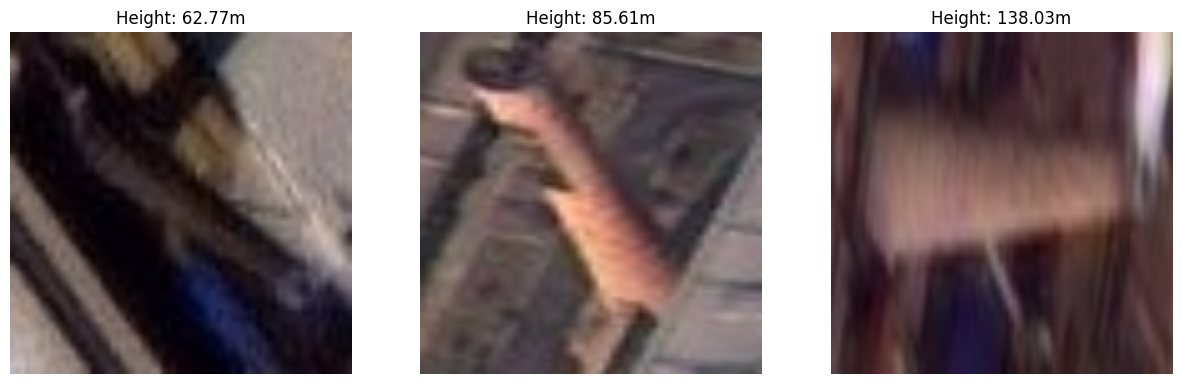

In [10]:
# 8. 데이터로더 생성 및 샘플 확인
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 이미지 변환(transform) 정의 (ImageNet 표준 정규화 사용)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 및 데이터로더 생성
train_dataset = HeightDataset(train_df, transform=transform)
valid_dataset = HeightDataset(valid_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("데이터로더 생성 완료.")

# --- 데이터셋 샘플 시각화 ---
def show_sample(dataset, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img_tensor, height = dataset[np.random.randint(len(dataset))]
        img = img_tensor.permute(1, 2, 0).numpy()
        mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
        img = (img * std + mean).clip(0, 1) # 정규화 해제
        axes[i].imshow(img)
        axes[i].set_title(f"Height: {height.item():.2f}m")
        axes[i].axis('off')
    plt.show()

print("\n--- 학습 데이터 샘플 (모델에 입력될 최종 이미지) ---")
show_sample(train_dataset)

In [11]:
# 9 . ResNet 모델 및 학습 함수 정의
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# 1. 모델 정의
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1) # 마지막 레이어를 높이 값 1개를 예측하도록 변경
model.to(DEVICE)

# 2. 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 3. 학습/평가 함수 정의
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50, patience=5):
    best_rmse = float('inf')
    epochs_no_improve = 0
    history = {'train_rmse': [], 'valid_rmse': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_rmse = np.sqrt(running_loss / len(train_loader.dataset))
        history['train_rmse'].append(train_rmse)

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)

        valid_rmse = np.sqrt(valid_loss / len(valid_loader.dataset))
        history['valid_rmse'].append(valid_rmse)

        print(f"Epoch {epoch+1}/{num_epochs} - Train RMSE: {train_rmse:.4f}, Valid RMSE: {valid_rmse:.4f}")

        if valid_rmse < best_rmse:
            best_rmse = valid_rmse
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
            print(f"  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: {best_rmse:.4f})")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\n{patience} 에포크 동안 성능 개선이 없어 학습을 조기 종료합니다.")
            break

    return model, history

print("모델 및 학습/평가 함수가 정의되었습니다.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 228MB/s]


모델 및 학습/평가 함수가 정의되었습니다.


In [12]:
# 10. 모델 학습 실행
model, history = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50, patience=7)

Epoch 1/50 [Train]: 100%|██████████| 331/331 [41:24<00:00,  7.51s/it]


Epoch 1/50 - Train RMSE: 105.8061, Valid RMSE: 90.5613
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 90.5613)


Epoch 2/50 [Train]: 100%|██████████| 331/331 [01:03<00:00,  5.22it/s]


Epoch 2/50 - Train RMSE: 82.9287, Valid RMSE: 73.9580
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 73.9580)


Epoch 3/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.43it/s]


Epoch 3/50 - Train RMSE: 58.7316, Valid RMSE: 50.8979
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 50.8979)


Epoch 4/50 [Train]: 100%|██████████| 331/331 [01:01<00:00,  5.39it/s]


Epoch 4/50 - Train RMSE: 37.4737, Valid RMSE: 28.5486
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 28.5486)


Epoch 5/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.50it/s]


Epoch 5/50 - Train RMSE: 22.1740, Valid RMSE: 18.3959
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 18.3959)


Epoch 6/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.46it/s]


Epoch 6/50 - Train RMSE: 14.3301, Valid RMSE: 9.2851
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 9.2851)


Epoch 7/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.43it/s]


Epoch 7/50 - Train RMSE: 12.0840, Valid RMSE: 8.2683
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 8.2683)


Epoch 8/50 [Train]: 100%|██████████| 331/331 [01:01<00:00,  5.38it/s]


Epoch 8/50 - Train RMSE: 10.8826, Valid RMSE: 10.0159


Epoch 9/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.49it/s]


Epoch 9/50 - Train RMSE: 11.0326, Valid RMSE: 7.9987
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 7.9987)


Epoch 10/50 [Train]: 100%|██████████| 331/331 [01:01<00:00,  5.41it/s]


Epoch 10/50 - Train RMSE: 9.9420, Valid RMSE: 9.7177


Epoch 11/50 [Train]: 100%|██████████| 331/331 [01:02<00:00,  5.29it/s]


Epoch 11/50 - Train RMSE: 9.6979, Valid RMSE: 9.5437


Epoch 12/50 [Train]: 100%|██████████| 331/331 [00:59<00:00,  5.59it/s]


Epoch 12/50 - Train RMSE: 8.9356, Valid RMSE: 7.4828
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 7.4828)


Epoch 13/50 [Train]: 100%|██████████| 331/331 [01:03<00:00,  5.24it/s]


Epoch 13/50 - Train RMSE: 8.5514, Valid RMSE: 9.8466


Epoch 14/50 [Train]: 100%|██████████| 331/331 [01:02<00:00,  5.32it/s]


Epoch 14/50 - Train RMSE: 8.0283, Valid RMSE: 9.5519


Epoch 15/50 [Train]: 100%|██████████| 331/331 [01:03<00:00,  5.25it/s]


Epoch 15/50 - Train RMSE: 7.3723, Valid RMSE: 13.1481


Epoch 16/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.45it/s]


Epoch 16/50 - Train RMSE: 7.5647, Valid RMSE: 9.1555


Epoch 17/50 [Train]: 100%|██████████| 331/331 [00:58<00:00,  5.69it/s]


Epoch 17/50 - Train RMSE: 7.2433, Valid RMSE: 7.2178
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 7.2178)


Epoch 18/50 [Train]: 100%|██████████| 331/331 [00:59<00:00,  5.60it/s]


Epoch 18/50 - Train RMSE: 6.1577, Valid RMSE: 6.5778
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 6.5778)


Epoch 19/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.44it/s]


Epoch 19/50 - Train RMSE: 6.3100, Valid RMSE: 7.9125


Epoch 20/50 [Train]: 100%|██████████| 331/331 [01:01<00:00,  5.39it/s]


Epoch 20/50 - Train RMSE: 5.9867, Valid RMSE: 9.4813


Epoch 21/50 [Train]: 100%|██████████| 331/331 [00:55<00:00,  5.94it/s]


Epoch 21/50 - Train RMSE: 5.7774, Valid RMSE: 6.4237
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 6.4237)


Epoch 22/50 [Train]: 100%|██████████| 331/331 [00:56<00:00,  5.89it/s]


Epoch 22/50 - Train RMSE: 5.8424, Valid RMSE: 6.6301


Epoch 23/50 [Train]: 100%|██████████| 331/331 [00:56<00:00,  5.86it/s]


Epoch 23/50 - Train RMSE: 5.5278, Valid RMSE: 7.3861


Epoch 24/50 [Train]: 100%|██████████| 331/331 [01:02<00:00,  5.29it/s]


Epoch 24/50 - Train RMSE: 5.5288, Valid RMSE: 6.9558


Epoch 25/50 [Train]: 100%|██████████| 331/331 [00:59<00:00,  5.58it/s]


Epoch 25/50 - Train RMSE: 5.3029, Valid RMSE: 6.2936
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 6.2936)


Epoch 26/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.44it/s]


Epoch 26/50 - Train RMSE: 4.9403, Valid RMSE: 6.8144


Epoch 27/50 [Train]: 100%|██████████| 331/331 [01:04<00:00,  5.16it/s]


Epoch 27/50 - Train RMSE: 4.5294, Valid RMSE: 7.1724


Epoch 28/50 [Train]: 100%|██████████| 331/331 [01:01<00:00,  5.35it/s]


Epoch 28/50 - Train RMSE: 4.6231, Valid RMSE: 8.7935


Epoch 29/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.45it/s]


Epoch 29/50 - Train RMSE: 4.5934, Valid RMSE: 7.5757


Epoch 30/50 [Train]: 100%|██████████| 331/331 [00:59<00:00,  5.59it/s]


Epoch 30/50 - Train RMSE: 4.1073, Valid RMSE: 6.4478


Epoch 31/50 [Train]: 100%|██████████| 331/331 [01:02<00:00,  5.33it/s]


Epoch 31/50 - Train RMSE: 4.4668, Valid RMSE: 6.2937


Epoch 32/50 [Train]: 100%|██████████| 331/331 [01:02<00:00,  5.31it/s]


Epoch 32/50 - Train RMSE: 4.2942, Valid RMSE: 6.2650
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 6.2650)


Epoch 33/50 [Train]: 100%|██████████| 331/331 [01:03<00:00,  5.22it/s]


Epoch 33/50 - Train RMSE: 4.1729, Valid RMSE: 6.3276


Epoch 34/50 [Train]: 100%|██████████| 331/331 [01:00<00:00,  5.50it/s]


Epoch 34/50 - Train RMSE: 4.1149, Valid RMSE: 6.3900


Epoch 35/50 [Train]: 100%|██████████| 331/331 [01:01<00:00,  5.42it/s]


Epoch 35/50 - Train RMSE: 3.8991, Valid RMSE: 6.6478


Epoch 36/50 [Train]: 100%|██████████| 331/331 [01:01<00:00,  5.37it/s]


Epoch 36/50 - Train RMSE: 4.5959, Valid RMSE: 6.8887


Epoch 37/50 [Train]: 100%|██████████| 331/331 [01:04<00:00,  5.17it/s]


Epoch 37/50 - Train RMSE: 3.7928, Valid RMSE: 6.7759


Epoch 38/50 [Train]: 100%|██████████| 331/331 [01:05<00:00,  5.08it/s]


Epoch 38/50 - Train RMSE: 3.6947, Valid RMSE: 6.2581
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 6.2581)


Epoch 39/50 [Train]: 100%|██████████| 331/331 [01:02<00:00,  5.26it/s]


Epoch 39/50 - Train RMSE: 3.5485, Valid RMSE: 6.2782


Epoch 40/50 [Train]: 100%|██████████| 331/331 [01:03<00:00,  5.22it/s]


Epoch 40/50 - Train RMSE: 3.3839, Valid RMSE: 7.0545


Epoch 41/50 [Train]: 100%|██████████| 331/331 [01:03<00:00,  5.25it/s]


Epoch 41/50 - Train RMSE: 3.4692, Valid RMSE: 6.3132


Epoch 42/50 [Train]: 100%|██████████| 331/331 [01:02<00:00,  5.31it/s]


Epoch 42/50 - Train RMSE: 3.5008, Valid RMSE: 5.9452
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 5.9452)


Epoch 43/50 [Train]: 100%|██████████| 331/331 [01:01<00:00,  5.36it/s]


Epoch 43/50 - Train RMSE: 3.3632, Valid RMSE: 6.4451


Epoch 44/50 [Train]: 100%|██████████| 331/331 [01:03<00:00,  5.19it/s]


Epoch 44/50 - Train RMSE: 3.3518, Valid RMSE: 5.8805
  -> Validation RMSE 개선! 모델을 'best_model.pt'에 저장합니다. (Best RMSE: 5.8805)


Epoch 45/50 [Train]: 100%|██████████| 331/331 [01:05<00:00,  5.02it/s]


Epoch 45/50 - Train RMSE: 3.0825, Valid RMSE: 6.1915


Epoch 46/50 [Train]: 100%|██████████| 331/331 [01:04<00:00,  5.10it/s]


Epoch 46/50 - Train RMSE: 3.1350, Valid RMSE: 7.3032


Epoch 47/50 [Train]: 100%|██████████| 331/331 [01:02<00:00,  5.30it/s]


Epoch 47/50 - Train RMSE: 2.9147, Valid RMSE: 6.0226


Epoch 48/50 [Train]: 100%|██████████| 331/331 [01:03<00:00,  5.24it/s]


Epoch 48/50 - Train RMSE: 3.3434, Valid RMSE: 6.3581


Epoch 49/50 [Train]: 100%|██████████| 331/331 [01:03<00:00,  5.20it/s]


Epoch 49/50 - Train RMSE: 3.1413, Valid RMSE: 6.7615


Epoch 50/50 [Train]: 100%|██████████| 331/331 [01:04<00:00,  5.16it/s]


Epoch 50/50 - Train RMSE: 3.3185, Valid RMSE: 6.8789


In [14]:
# 11. 최종 성능계산
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm

# 가장 성능이 좋았던 모델 가중치 불러오기
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# --- 최종 RMSE 계산 ---
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(valid_loader, desc="Final Evaluation"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# 최종 Line-level RMSE 계산 및 출력
final_rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
print("\n---" * 15)
print(f"✅ [Final] Line-level RMSE: {final_rmse:.4f}")
print("---" * 15)

Final Evaluation: 100%|██████████| 42/42 [00:07<00:00,  5.43it/s]


---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
✅ [Final] Line-level RMSE: 5.8805
---------------------------------------------
